In [ ]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG',
                      start=start_date,
                      end=end_date,
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

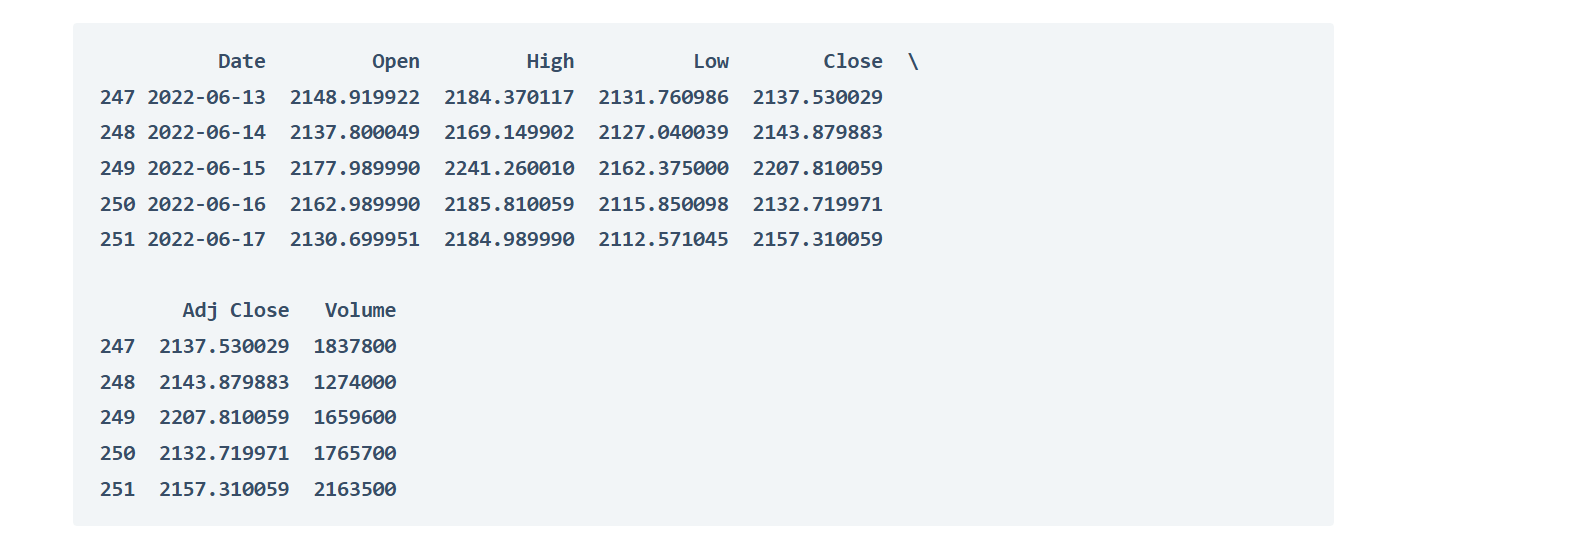

In [10]:
data = data[["Date", "Close"]]
print(data.head())

Price            Date       Close
Ticker                       GOOG
Date                             
2024-03-08 2024-03-08  135.802032
2024-03-11 2024-03-11  138.442566
2024-03-12 2024-03-12  139.120117
2024-03-13 2024-03-13  140.266022
2024-03-14 2024-03-14  143.823227


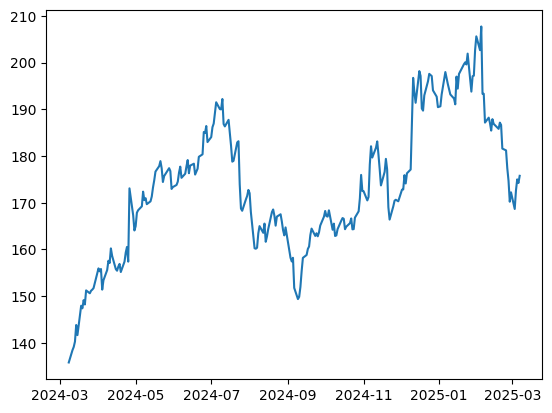

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

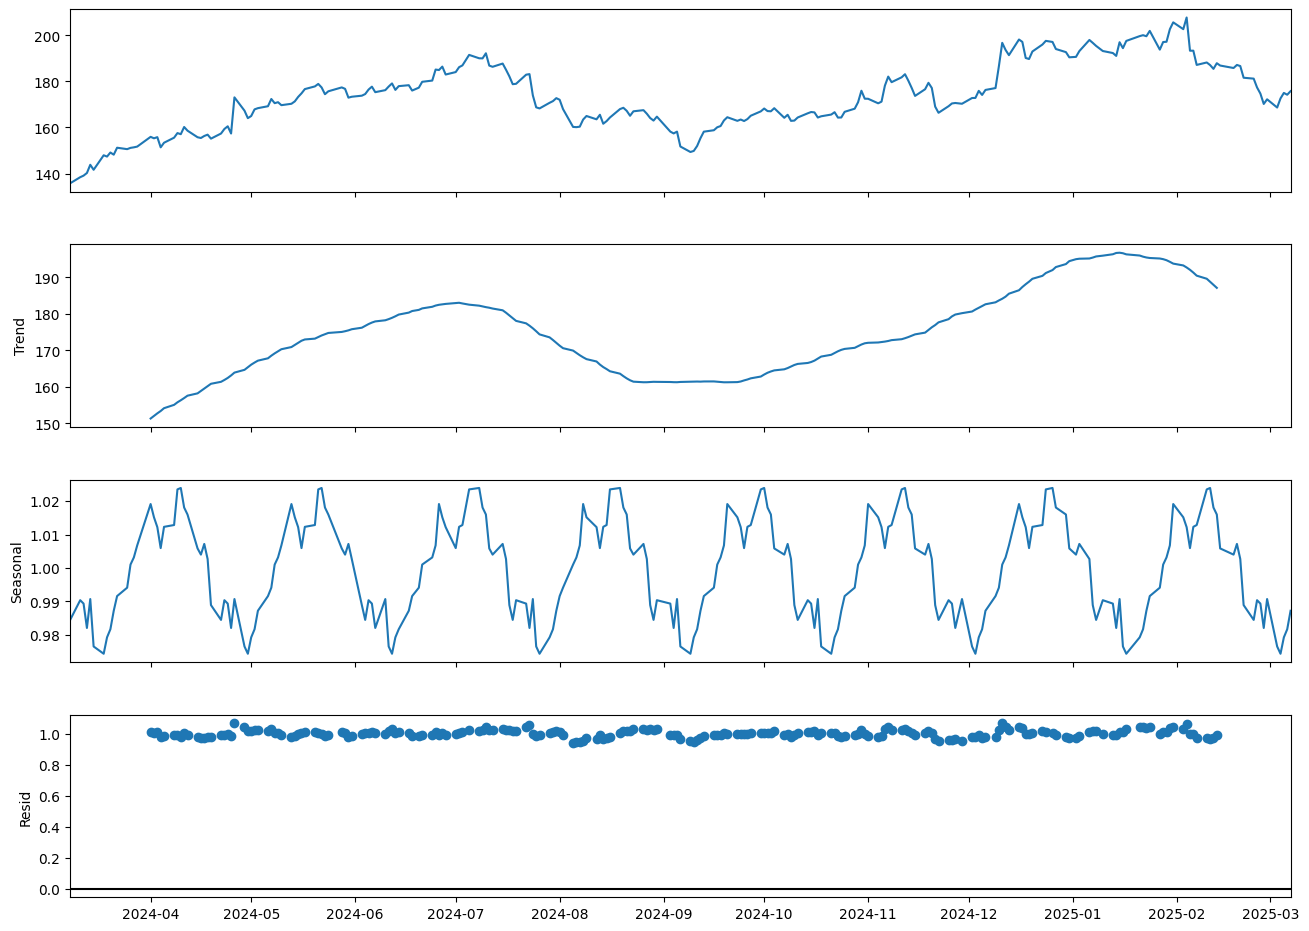

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'data["Close"]' is a pandas Series with datetime index
result = seasonal_decompose(data["Close"], model='multiplicative', period=30)  # Replace freq with period

# Plot the decomposition
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)

So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. It will help you learn using both models.

To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

Now here’s how to find the value of p:

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

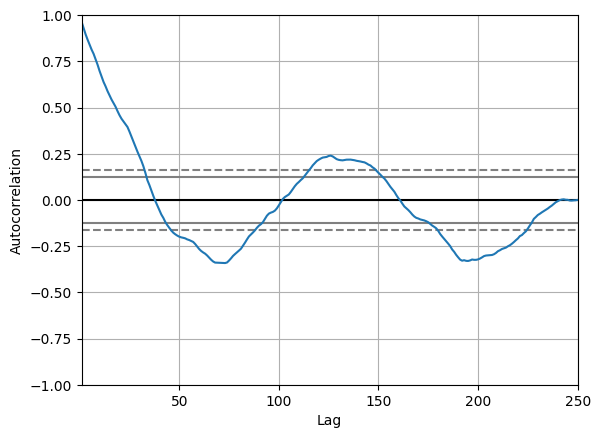

In [22]:
pd.plotting.autocorrelation_plot(data["Close"])

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

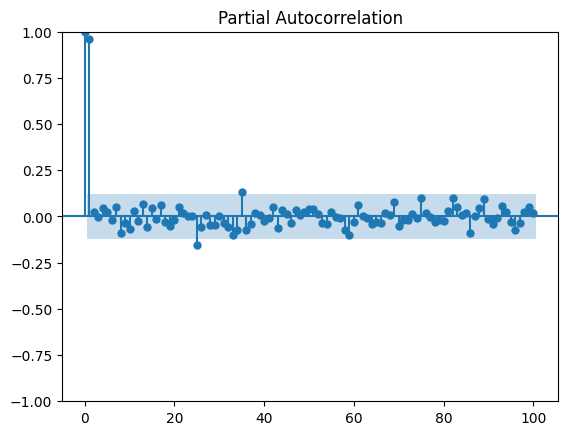

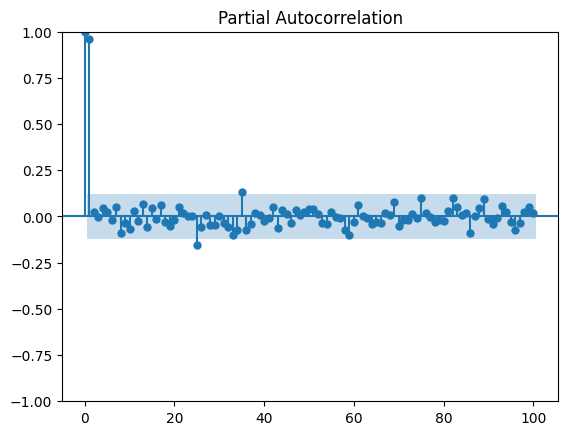

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2. Now let’s build an ARIMA model:

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                   GOOG   No. Observations:                  250
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -632.977
Date:                Sat, 08 Mar 2025   AIC                           1281.954
Time:                        21:00:18   BIC                           1310.094
Sample:                             0   HQIC                          1293.281
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8009      0.057     14.138      0.000       0.690       0.912
ar.L2         -0.9623      0.082    -11.767      0.000      -1.123      -0.802
ar.L3         -0.0781      0.087     -0.897      0.3

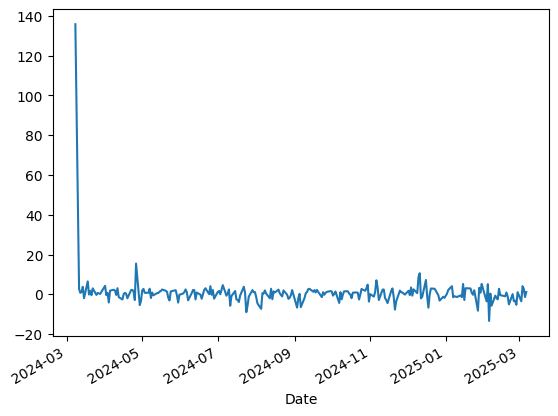

In [26]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Define the ARIMA model parameters
p, d, q = 5, 1, 2

# Fit the ARIMA model
model = ARIMA(data["Close"], order=(p, d, q))
fitted = model.fit()

# Print the summary of the model
print(fitted.summary())

# Plot the residuals
fitted.resid.plot()
plt.show()

Here’s how to predict the values using the ARIMA model:



In [27]:
predictions = fitted.predict()
print(predictions)

Date
2024-03-08      0.000000
2024-03-11    135.802002
2024-03-12    138.381968
2024-03-13    139.061960
2024-03-14    140.045653
                 ...    
2025-03-03    172.175284
2025-03-04    168.522813
2025-03-05    172.258974
2025-03-06    175.588012
2025-03-07    174.584556
Name: predicted_mean, Length: 250, dtype: float64


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [28]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

                                     SARIMAX Results                                      
Dep. Variable:                               GOOG   No. Observations:                  250
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -611.554
Date:                            Sat, 08 Mar 2025   AIC                           1253.108
Time:                                    21:02:23   BIC                           1305.129
Sample:                                         0   HQIC                          1274.075
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0419      0.206     -0.204      0.839      -0.445       0.361
ar.L2          0.8486      0.233   

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:



In [29]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

250    174.276531
251    175.881875
252    172.557667
253    172.933246
254    170.993999
255    172.136259
256    171.318000
257    169.950589
258    169.674751
259    169.858582
260    170.180828
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

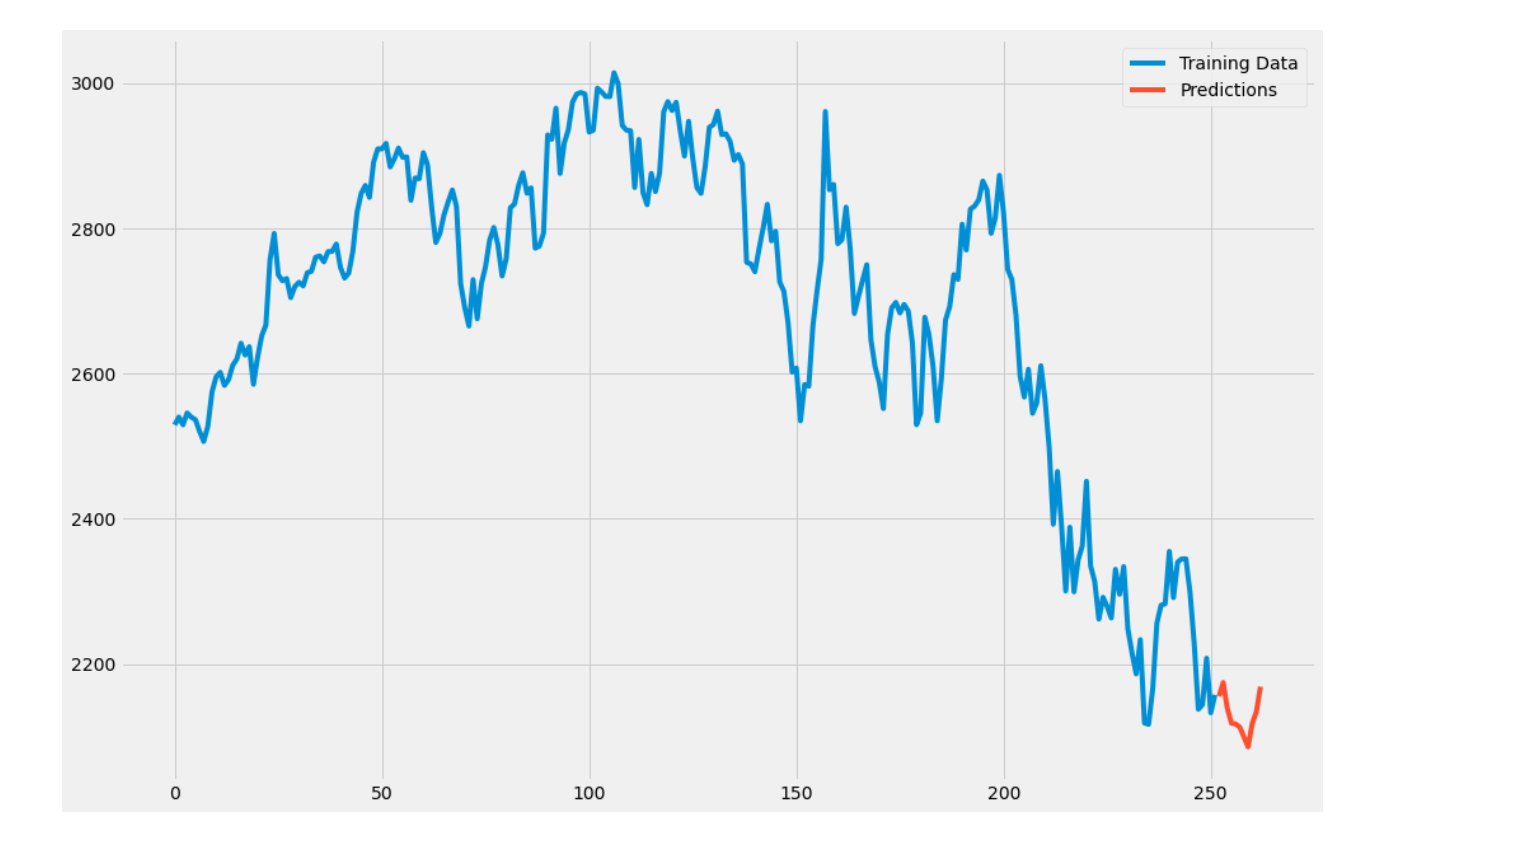